In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import lbg_forecast.population_model as pop
from scipy.stats import t
from astropy.cosmology import WMAP9 as cosmo

Text(0.5, 0, 'Lookback Time [Gyr]')

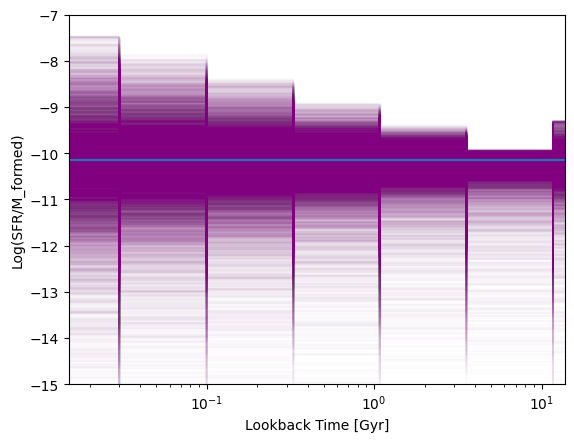

In [2]:
#goldrush colour track bins
age_bins = np.log10(np.array([[69*0.001, 71*0.001],
        [71*0.001, 100*0.001],
        [100*0.001, 330*0.001],  
        [330*0.001, 1.1], 
        [1.1, 3.6],
        [3.6, 11.7],
        [11.7, 13.7]])*10**9)

#standard bins
age_bins = np.log10(np.array([[10**-9, 30*0.001],
                [30*0.001, 100*0.001],
                [100*0.001, 330*0.001],  
                [330*0.001, 1.1], 
                [1.1, 3.6],
                [3.6, 11.7],
                [11.7, 13.7]])*10**9)

nu = 2
nbins = len(age_bins)
sigma = np.array([0.3]*(nbins-1))
mu = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
nsamples = 10000
mass_norm = 10**10
massesformed = []
ages = []
recentsfhs = []
redshift = 0
tuniv = cosmo.age(redshift).value
new_age_bins = sfh.zred_to_agebins(redshift, age_bins)
indx=0
while(indx < nsamples):

    tabulatedsfh, masses = sfh.continuity_sfh(new_age_bins, pop.continuity_prior(1, nu, mu, sigma)[0,:], mass_norm)
    times = tuniv-tabulatedsfh[0]
    mformed = np.trapz(tabulatedsfh[1], tabulatedsfh[0])*mass_norm
    massesformed.append(mformed)
    pointsfr = np.reshape(np.flip(tabulatedsfh[1]), (nbins, 2))[:, 0]
    ages.append(sfh.mwa(pointsfr, new_age_bins, mass_norm))
    recentsfhs.append(sfh.nonpar_recent_sfr(masses, new_age_bins))
    plt.plot(times, np.log10(tabulatedsfh[1]/mass_norm), color="purple", alpha=0.01)

    indx+=1

ages = np.asarray(ages)
recentsfhs = np.asarray(recentsfhs)

plt.plot(tuniv - 10**new_age_bins[:, 1]/(10**9), np.log10(np.ones_like(new_age_bins[:, 1])*((1.0)/(tuniv*10**9))))
plt.xlim(0.015, tuniv)
plt.ylim(-15, -7)
plt.xscale("log")
plt.ylabel("Log(SFR/M_formed)")
plt.xlabel("Lookback Time [Gyr]")


(0.0, 13.768899116929322)

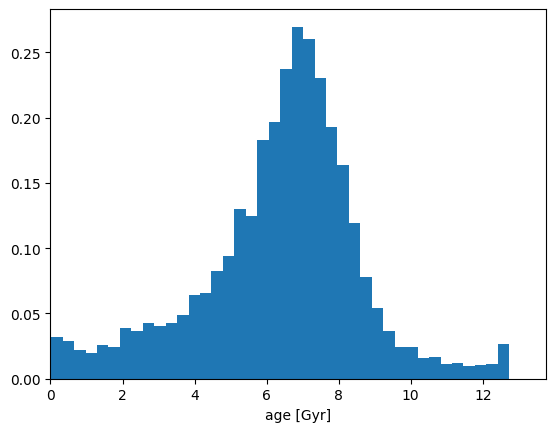

In [3]:
plt.hist(ages, bins=40, density=True)
plt.xlabel("age [Gyr]")
ages
plt.xlim(0, tuniv)
#plt.xlim(0.03, 0.70)

(-12.0, -7.8)

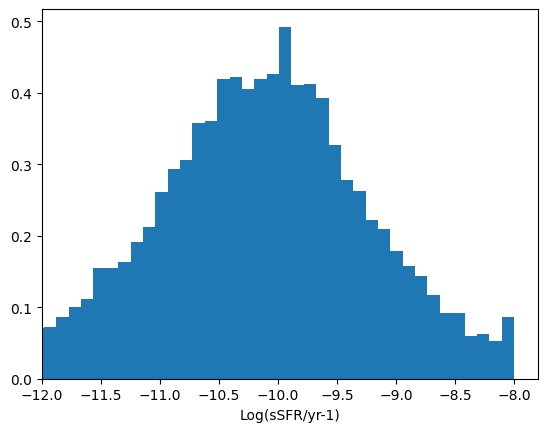

In [4]:
plt.hist(np.log10(recentsfhs/(mass_norm)), bins=100, density=True)
plt.xlabel("Log(sSFR/yr-1)")
plt.xlim(-12, -7.8)

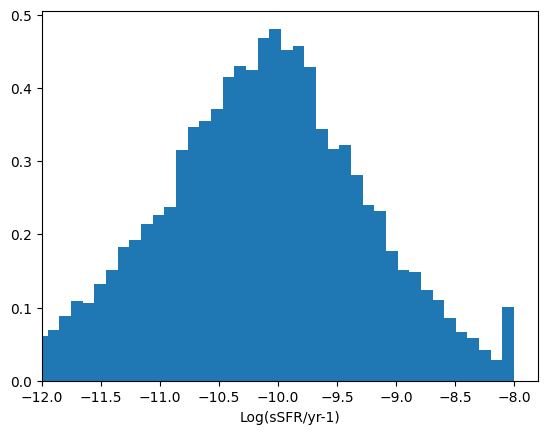

In [5]:
sfh.test_recent_sfr()